<a href="https://colab.research.google.com/github/majidsh97/VAE/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets


In [157]:
import datasets
from torchsummary import summary
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
"""

lazwRow?
custom collaborate function

"""

data = datasets.load_dataset('fashion_mnist')
batch_size = 256*4


train = data['train']#.select(range(100))
test_data = data['test']


data_transform=  transforms.Compose([
    #transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x*2-1)

])
def custom_collate_fn(batch):
    images = [data_transform(x['image']) for x in batch]
    labels = torch.tensor([x['label'] for x in batch])
    return torch.stack(images).cuda(), labels.cuda()

sampler = torch.utils.data.RandomSampler(train,num_samples=256*4)
train_loader = DataLoader(train,batch_size, collate_fn=custom_collate_fn, sampler=sampler)


for image,label in train_loader:
  print(image.shape)
  print(image.max())
  print(image.min())
  break



torch.Size([1024, 1, 28, 28])
tensor(1., device='cuda:0')
tensor(-1., device='cuda:0')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 14, 14]           1,280
              ReLU-2          [-1, 128, 14, 14]               0
 AdaptiveAvgPool2d-3            [-1, 128, 1, 1]               0
           Flatten-4                  [-1, 128]               0
            Linear-5                  [-1, 256]          33,024
            Conv2d-6            [-1, 256, 7, 7]         295,168
              ReLU-7            [-1, 256, 7, 7]               0
           Flatten-8                [-1, 12544]               0
            Linear-9                  [-1, 256]       3,211,520
           Linear-10                  [-1, 256]          65,792
           Linear-11                  [-1, 256]          33,024
           Linear-12                [-1, 12544]       3,223,808
        Unflatten-13            [-1, 256, 7, 7]               0
  ConvTranspose2d-14          [-1, 128,

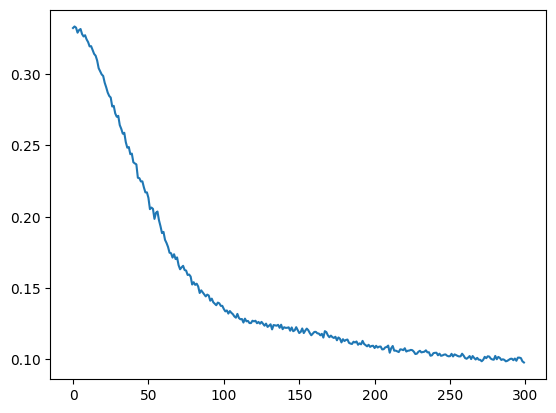

In [176]:
from torch.nn import Conv2d,ReLU,Linear,ConvTranspose2d,LeakyReLU,Tanh,Flatten,Unflatten,Sigmoid,AdaptiveAvgPool2d,Sequential


def kl_divergence(mean,std):
    normal = torch.distributions.Normal(torch.zeros_like(mean),torch.ones_like(std))
    p = torch.distributions.Normal(mean,std)
    kl = torch.distributions.kl_divergence(normal,p)
    loss = torch.mean(kl)
    return loss

mse = torch.nn.MSELoss()
f=128
pad=1
latent_size = 128
class Encoder_Decoder(torch.nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.encoder1 =  torch.nn.Sequential(
        Conv2d(1,f,3,2,pad),
        ReLU())
        self.avg1= AdaptiveAvgPool2d((1,1))
        self.f1 = Flatten()
        self.l1 = Linear(f,2*f)
        self.encoder2 = Sequential(
        Conv2d(f,2*f,3,2,pad),
        ReLU(),
        Flatten(),
        Linear(2*f*7*7,256),
        Linear(256,latent_size*2))

        self.decoder2 = torch.nn.Sequential(

        Linear(latent_size,256),
        Linear(256,2*f*7*7),
        Unflatten(1,(2*f,7,7)),
        ConvTranspose2d(2*f,f,3,2,pad,1),
        ReLU())
        self.decoder1=Sequential(
        #ConvTranspose2d(f,f,1,1,0),
        #ReLU(),
        ConvTranspose2d(f,1,3,2,pad,1),
        Sigmoid())

    def forward(self,input):
        out_e1 = self.encoder1(input) 
        #---------------------------------
        o = self.avg1(out_e1)
        o = self.f1(o)
        o = self.l1(o)
        mean1 = o[:,:f]
        var1 = o[:,f:]
        std1 = torch.exp(1/2*var1)
        eps1 = torch.normal(0,1,size=out_e1.shape).cuda()
        mean1 = mean1.reshape((out_e1.shape[0],out_e1.shape[1],1,1))
        std1 = std1.reshape((out_e1.shape[0],out_e1.shape[1],1,1))
        z1 = mean1+std1+eps1
        #print('z1',eps1.shape,mean1.shape)
        #------------------------------------
        encode = self.encoder2(out_e1)
        mean = encode[:,latent_size:]
        var = encode[:,:latent_size]
        #print(mean.shape,var.shape)

        eps = torch.normal(0,1,size=mean.shape).cuda()
        std = torch.exp(1/2*var)
        z = mean + std*eps

        out_d2 = self.decoder2(z)
        out_d1 = self.decoder1(out_d2+z1)
        return out_d1 , mean , std,mean1[:,:,0,0],std1[:,:,0,0]
        pass

    #Tanh()

encoder_decoder = Encoder_Decoder().cuda()
summary(encoder_decoder,(1,28,28),device="cuda")

lr = 1e-3
optim = torch.optim.RAdam(encoder_decoder.parameters(),lr,weight_decay=1e-5)

def step(x,y)->torch.Tensor:
    optim.zero_grad()
    output,mean,std ,mean1,std1= encoder_decoder.forward(x)
    
    loss = mse(output,y) +1/2*( kl_divergence(mean,std) + kl_divergence(mean1,std1))
    loss.backward()
    optim.step()
    return loss
    pass

train_loss = []
for epoch in range(300):
    for image,label in train_loader:
        #print(image.shape)
        #print(label.shape)
        #noise = torch.normal(0,1,size=(image.shape[0],1,28,28)).cuda()
        loss = step(image,(image+1)/2)
        #print(loss)
        train_loss.append(loss.cpu().detach().numpy())
        
        pass

    print(epoch,': ',train_loss[-1])
    #break

plt.plot(train_loss)

torch.Size([12, 28, 28, 1])


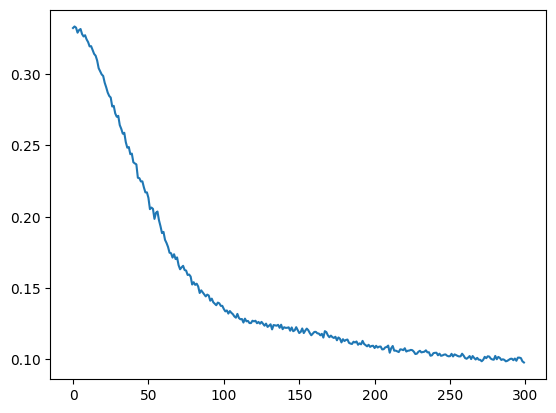

<Figure size 100x100 with 0 Axes>

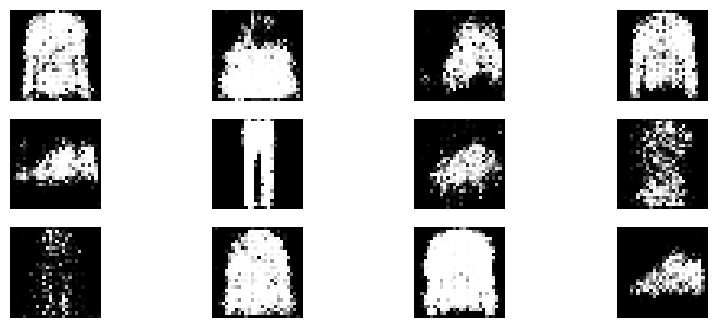

<Figure size 100x100 with 0 Axes>

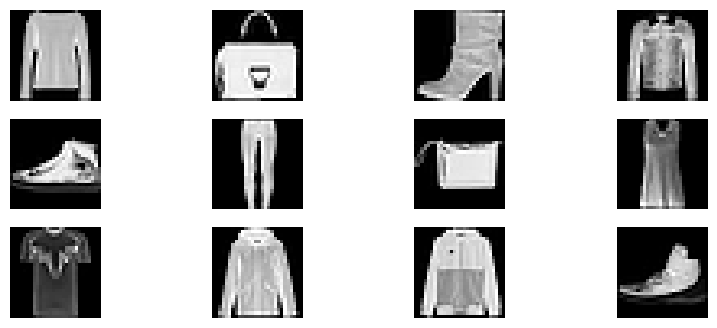

In [177]:
plt.plot(train_loss)

def show_preds(input,image=None):
    preds = input
    if image==None:
        preds:torch.Tensor = encoder_decoder(input)[0]
        preds =  preds.moveaxis(1,-1)
        print(preds.shape)
        preds=preds.cpu().detach().numpy()
    plt.figure(figsize=(1,1))
    fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(10, 4))
    axs = axs.flatten()

    for i in range(preds.shape[0]):
        ax = axs[i]
        ax.imshow(preds[i],cmap='gray',interpolation='none')
        ax.axis('off')
    plt.show()

#noise = torch.normal(0,1,size=(12,1,28,28)).cuda()
#show_preds(noise)

for image,label in train_loader:
    show_preds(image[:12])
    show_preds(image[:12].cpu().moveaxis(1,-1),True)
    break


torch.Size([12, 28, 28, 1])


<Figure size 100x100 with 0 Axes>

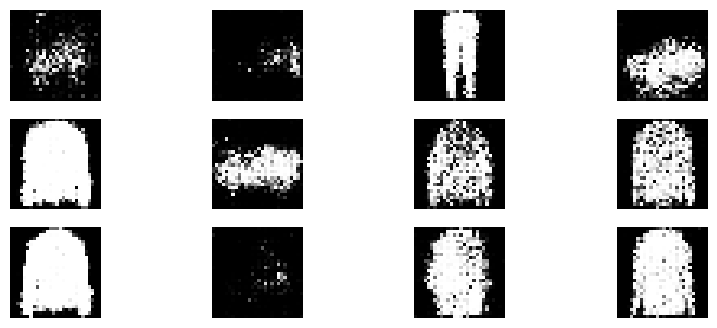

<Figure size 100x100 with 0 Axes>

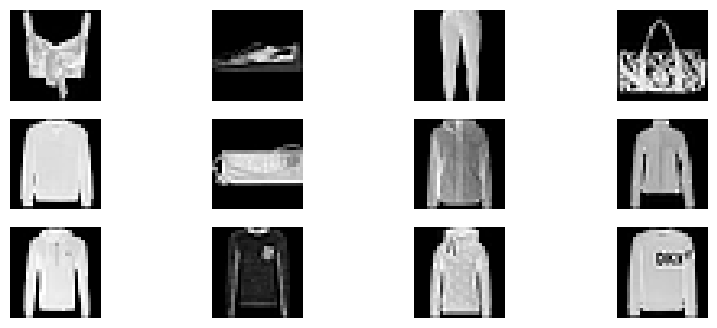

In [181]:
import torch.utils
import torch.utils.data


#test_data = test
sampler = torch.utils.data.RandomSampler(test_data,num_samples=1000)
test_loader = DataLoader(test_data,1000,collate_fn=custom_collate_fn,sampler=sampler)

image,lable = next(iter(test_loader))
show_preds(image[:12])
show_preds(image[:12].cpu().moveaxis(1,-1),True)




In [99]:
latent=0
def f(m,input,output):
    global latent
    latent=output

encoder_decoder.encoder[-1].register_forward_hook(f)

image,label = next(iter(test_loader))
pred = encoder_decoder.forward(image)[0]
#print(pred.shape)
plt.figure(figsize=(2,2))
fig,axs =plt.subplots(1,2)
axs[0].imshow(image[0].cpu().moveaxis(0,-1).numpy())
axs[0].set_title('image')
axs[1].imshow(pred[0].cpu().detach().moveaxis(0,-1).numpy())
axs[1].set_title('prediction')
plt.show()

latent=latent.detach().cpu()
t = latent
print(t.shape)
print(label.cpu().shape)
print(t[:,0].max())
plt.scatter(t[:,0],t[:,latent_size],c=label.cpu(),marker='.')




AttributeError: 'Encoder_Decoder' object has no attribute 'encoder'

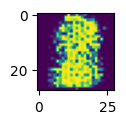

In [239]:
sample_ = torch.normal(0,1,size=(1,latent_size)).cuda()
#        out_d1 = self.decoder1(out_d2+z1)
pred:torch.Tensor = encoder_decoder.decoder2(sample_)
sample2 = torch.normal(0,1,size=pred.shape).cuda()

pred:torch.Tensor = encoder_decoder.decoder1(pred+sample2)

plt.figure(figsize=(1,1))
plt.imshow(pred[0].detach().cpu().moveaxis(0,-1))

In [ ]:
"""   self.c1 =  Conv2d(1,f,3,2,pad)
        self.r1= ReLU()
        self.c2= Conv2d(f,2*f,3,2,pad)
        self.r2= ReLU()
        self.f= Flatten()
        self.l1= Linear(2*f*7*7,256)
        self.l2= Linear(256,latent_size*2)

            

        self.ul2 = Linear(latent_size,256)
        self.ul1 = Linear(256,2*f*7*7)
        self.uf= Unflatten(1,(2*f,7,7))
        self.uc2 = ConvTranspose2d(2*f,f,3,2,pad,1)
        self.ur2 =ReLU()
        self.uc1= ConvTranspose2d(f,1,3,2,pad,1)
        self.s = Sigmoid()"""

<H1>Notes</H1>
normalization have huge imapact accidentally divide 255.0 and it wouldnt generate good samples